## Defining the Research Questions and Research Plan

### Research Aim (Exploratory):
- A review of literature has shown that house prices are often modeled using regression models whereby structural and locational attributes are used to explain variances in house prices. This is justified on the basis that houses often share similar strucutral features with their nearby properties (Basu & Thibodeau, 1998). In addition, poverty index has also been used to identify at-risk housing (Margulis, 1998). The current research aims to extend the literature by simultanously exploring the effect of deprivation index, quality rating, distance to station and nearby venue categories in predicting house price categories. 
    
    - Candiate Independent Variable: Nearby Venue Categories, Index of Multiple Deprivation, Quality rating, Distance to Station
    - Dependent Variable: Housing Price Categories
    
### Research Design:
   1. Data Preparation:
        -- Importing pre-existing datasets
              - London housing price by ward code __ downloaded from public database
              - London geographical coordinates _ downloaded from public database   
        -- Data Wangling:
              - Merge the three dataframe with the primary key: ward code 
              - Clean and simplify the dataset to reduce computation time
        -- Exploratory Data Analysis:
              - Explore the normality of target variable__ Housing Price and remove the outliers if there are any.
              - Its association with three candidate feature variables
                   1. Index of Multiple Deprivation
                   2. Distance to Station
                   3. Quality Rating
              - Conduct normality test for variables that appear to be associated with the housing price value 
                  - modify the data accordingly based on its distribution plot
              - Compute the correlation coefficient and its associated statistical significance
         
         -- Further data sourcing:
              - Fetch venue category data for each geographical coordinate using Foursquare API
         -- Further data wangling:
              - Convert Housing Price into categorical variable (low, medium, high)
              - Converting venue data into dummy variables using one-hot encoding 
    
   2. Modelling 
        -- Further feature selection:
            - apply Randomforest classifier to the entire dataset
            - generate a dataframe containing all the feature variables with its associated feature importance value
            - drop the features that failed to provide sufficient meaningful information
        -- Find the best classification model
            - apply Random Forest, K-Nearest Neighbors and Support Vector Machine using the selected feature variables
            - compute the accuracy score of each mode
            - select the one the highest accuracy score
            
   3. Results Interpretation and Discussion          
   

In [2]:
## Importing packages
from geopy.geocoders import Nominatim 
import requests
import json 
import pandas as pd
import numpy as np


## Importing datasets

In [3]:
 geo_data=pd.read_csv('london_postcodes.csv')

In [4]:
hp_data=pd.read_csv('london_house_price.csv')

In [194]:
len(hp_data.Ward_name.unique())

606

In [445]:
len(geo_data.Ward.unique())

638

## Data Wangling

In [786]:
#selecting the cells within the relavent timeframe
hp_data=hp_data[hp_data['Year']=='Year ending Dec 2017']
#selecting the mean values
hp_data=hp_data[hp_data['Measure']=='Mean']
hp_data=hp_data[hp_data['Value']!='-']
hp_data=hp_data.rename(columns={'Code':'RegionalCode'})

In [138]:
#checking for any unwanted duplicates in the code columns
mask=hp_data.groupby('RegionalCode').count()['Value']!=1
hp_data.groupby('RegionalCode').count()['Value'][mask]

Series([], Name: Value, dtype: int64)

In [824]:
#selecting relevant columns in the london geo dataset, 
#the last three columns are treated as candidate feature variables
filtered_geo=geo_data[['Latitude','Longitude','District','Ward','Ward Code','Distance to station','Index of Multiple Deprivation', 'Quality']]
#renaming the code column for inner join
filtered_geo=filtered_geo.rename(columns={'Ward Code':'RegionalCode'})

In [825]:
#merging the two datasets using inner join
merged_df=pd.merge(filtered_geo,
         hp_data[['RegionalCode','Value']],
         on='RegionalCode')

In [826]:
merged_df.shape

(273567, 9)

The dataset seems quite lengthy. Let's see if there is anything we could do about it

In [797]:
merged_df.head()

,Latitude,Longitude,District,Ward,RegionalCode,Distance to station,Index of Multiple Deprivation,Quality,Value
0,51.401546,0.015415,Bromley,Bromley Town,E05000109,0.218257,20532,1,"469,534"
1,51.406333,0.015208,Bromley,Bromley Town,E05000109,0.253666,10169,1,"469,534"
2,51.400057,0.016715,Bromley,Bromley Town,E05000109,0.044559,20532,1,"469,534"
3,51.404543,0.014195,Bromley,Bromley Town,E05000109,0.462939,19350,1,"469,534"
4,51.401392,0.014948,Bromley,Bromley Town,E05000109,0.227664,20532,1,"469,534"


It seems like the latitude and longitude values are very precise which narrow down wards into 
very specific areas, which to some extent, is a good thing. However, if these areas are too specific,as it might result in duplications when we fetch nearby venue data.

In [802]:
#Let's first shorten the dataframe by rounding the geo coordinates to 3 decimal places.
merged_df_1=merged_df.round(3)
len(merged_df_1.groupby(['Latitude','Longitude']).count())

81752

Although the dataframe is now shorter than the original one, we still have 81752 rows. This will result in significant computation time when we later use Foursquare API to fetch venue data for each row. Therefore, we shall try shortening it further by rounding up to 2 decimal places as this is also the standard format used in Foursquare API.

In [792]:
merged_df=merged_df.round(2)

In [793]:
len(merged_df.groupby(['Latitude','Longitude']).count())
#Now this is much shorter.

1809

In [197]:
merged_df.head()

,Latitude,Longitude,District,Ward,RegionalCode,Distance to station,Index of Multiple Deprivation,Quality,Value
0,51.40,0.02,Bromley,Bromley Town,E05000109,0.22,20532,1,469534.0
1,51.41,0.02,Bromley,Bromley Town,E05000109,0.25,10169,1,469534.0
2,51.40,0.02,Bromley,Bromley Town,E05000109,0.04,20532,1,469534.0
3,51.40,0.01,Bromley,Bromley Town,E05000109,0.46,19350,1,469534.0
4,51.40,0.02,Bromley,Bromley Town,E05000109,0.23,20532,1,469534.0


In [198]:
#Removing the ',' and converting the price value into float
merged_df['Value']=merged_df['Value'].replace(',','',regex=True).astype('float64')

In [199]:
#identifying the unique price value for each coordinate
grouped_df=merged_df.groupby(['Latitude','Longitude']).mean().reset_index()

In [200]:
grouped_df.shape

(1810, 6)

In [201]:
RC=merged_df.groupby(['Latitude','Longitude'])['RegionalCode'].apply(lambda x: set(x.tolist()))


In [202]:
#converting set into list and selecting the first item in the list
RC_list=[]
for i in RC:
    RC_list.append(list(i))

Code=[]

for i in range(len(RC_list)):
    Code.append(RC_list[i][0])    

len(Code)

1810

In [203]:
#appending the areacode to the grouped_df
grouped_df['Code']=Code

In [204]:
grouped_df.head()

,Latitude,Longitude,Distance to station,Index of Multiple Deprivation,Quality,Value,Code
0,51.29,0.06,6.12000,19725.000000,1.000000,575544.000000,E05000117
1,51.29,0.07,6.74000,19725.000000,1.000000,575544.000000,E05000117
2,51.30,0.02,5.03625,23230.000000,1.875000,378844.000000,E05000107
3,51.30,0.03,5.18200,25924.000000,1.000000,378844.000000,E05000107
4,51.30,0.04,5.92000,20042.636364,2.272727,539780.363636,E05000107


In [205]:
#checking if there is any null value
grouped_df.dropna().shape

(1810, 7)

Now we have merged and shortened the length of the housing price and london geo dataset. Before moving on to source venue data, we shall now carry out exploratory data analysis on the existing feature and target variables for feature selection.

### Exploratory Data Analysis

Existing candidate feature variables: Distance to Station,Index of Multiple Deprivation, Quality Rating

In [206]:
##Exploring price value

#descriptive stats summary
grouped_df['Value'].describe()

count    1.810000e+03
mean     5.761378e+05
std      3.330070e+05
min      2.599718e+05
25%      3.927840e+05
50%      5.046423e+05
75%      6.288940e+05
max      3.624164e+06
Name: Value, dtype: float64

In [207]:
import seaborn as sns
from scipy.stats import norm
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


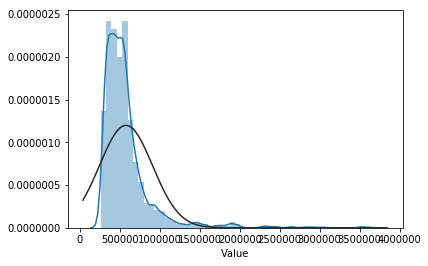

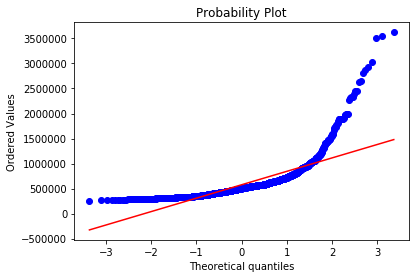

In [212]:
# histogram and normal probability plot
sns.distplot(grouped_df['Value'],fit=norm)
fig=plt.figure()
res=stats.probplot(grouped_df['Value'],plot=plt)

From the above distribution plot, we could see the price value deviate from normal distribution with positive skewness and high peakedness. Let's find out more about it.

In [209]:

print("Skewness: %f" % grouped_df['Value'].skew())
print("Kurtosis: %f" % grouped_df['Value'].kurt())

Skewness: 3.874237
Kurtosis: 21.852947


The skewness and kurtosis seems to be quite high. There are quite a few outliers above the 3000000 price point, let's see what we could do about it.

In [219]:

grouped_df.sort_values(by='Value',ascending=False).head()

,Latitude,Longitude,Distance to station,Index of Multiple Deprivation,Quality,Value,Code
801,51.50,-0.17,0.500909,21629.630854,3.214876,3.624164e+06,E05009389
802,51.50,-0.16,0.331698,19357.174165,3.413643,3.547302e+06,E05009403
803,51.50,-0.15,0.306286,20728.318095,3.099048,3.514427e+06,E05000637
862,51.51,-0.15,0.333911,17880.248130,1.951787,3.035658e+06,E05000641
863,51.51,-0.14,0.296197,13070.137135,2.417059,2.921195e+06,E05000644


In [827]:
#Dropping the four outliers
filtered_df=grouped_df.drop(grouped_df[grouped_df['Value']>3000000].index)

In [828]:
#Checking if the outliers are dropped correctly
filtered_df.sort_values(by='Value',ascending=False).head()

,Latitude,Longitude,Distance to station,Index of Multiple Deprivation,Quality,Value,Code
863,51.51,-0.14,0.296197,13070.137135,2.417059,2.921195e+06,E05000644
930,51.52,-0.15,0.386573,19523.701121,1.911703,2.860267e+06,E05000641
800,51.50,-0.18,0.419418,23232.576419,2.425036,2.803907e+06,E05009401
799,51.50,-0.19,0.307586,21810.589354,2.958175,2.658732e+06,E05009388
861,51.51,-0.16,0.262131,17749.051823,2.285988,2.632389e+06,E05000641


C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


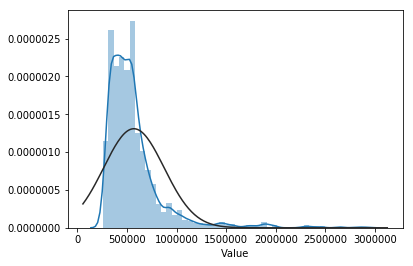

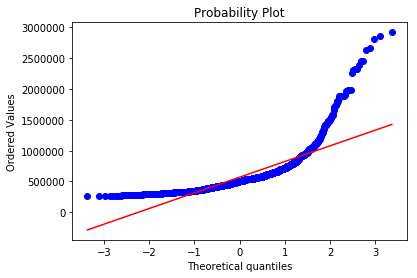

In [829]:
#plotting the distribution again

sns.distplot(filtered_df['Value'],fit=norm)
fig=plt.figure()
res=stats.probplot(filtered_df['Value'],plot=plt)

C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


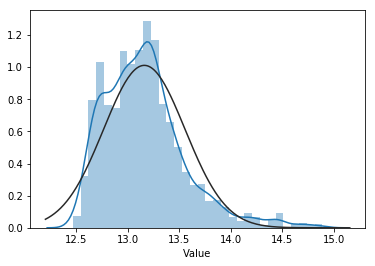

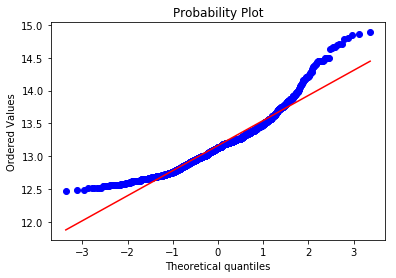

In [830]:
#Before removing any more outliers,let's check the logtransfomred plot
transformed_price=np.log(filtered_df['Value'])
sns.distplot(transformed_price,fit=norm)
fig=plt.figure()
res=stats.probplot(transformed_price,plot=plt)

Despite the relatively poor fit at the outer range,the distribution now looks a lot similar to the normal probability plot compared to the initial plot. We shall leave it for now as we might loose some important information if we remove too many outer range values. 

We shall now move on to examine our candidate features.

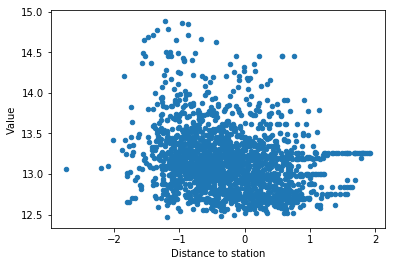

In [831]:
##Examining our first variable：Distance to Station
var='Distance to station'
data=pd.concat([transformed_price,np.log(filtered_df[var])],axis=1)
data.plot.scatter(x=var,y='Value')

Seems like our first candidate variable is not associated with the housing price, we shall exclude it from our model.

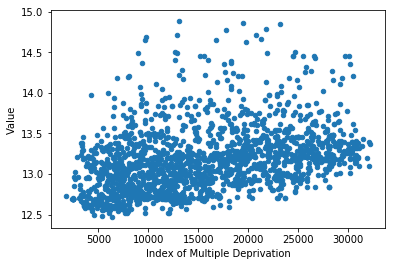

In [832]:
##Examining the second variable：Index of Multiple Deprivation
var='Index of Multiple Deprivation'
data=pd.concat([transformed_price,filtered_df[var]],axis=1)
data.plot.scatter(x=var,y='Value')

Interesting, the second feature variable does appear to be somewhat positively associated with the price value. However, the slope appears to be quite flat, it is possible that they are only weakly associated. Let's examine this variable in more details.

C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


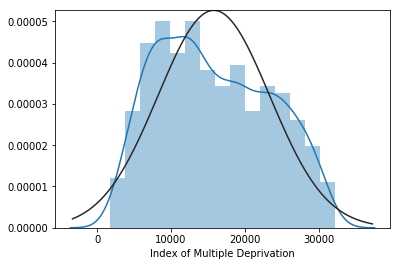

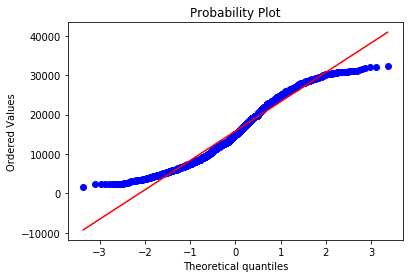

In [833]:
#Distribution Plot of the multiple index of deprivation
sns.distplot(filtered_df[var],fit=norm)
fig=plt.figure()
res=stats.probplot(filtered_df[var],plot=plt)

In [834]:

print("Skewness: %f" % filtered_df['Index of Multiple Deprivation'].skew())
print("Kurtosis: %f" % filtered_df['Index of Multiple Deprivation'].kurt())

Skewness: 0.231209
Kurtosis: -1.039848


From the distribution plot, we could see both tails (low end:below 5000; high end: above 30000) of the distribution have contributed to the poor fit. 

In [836]:
#We can see that most of the values at the higher end are indeed around 30000. 
#For the higher end, we shall set the outliers threshold at 30000.
filtered_df[var].sort_values(ascending=False).head(20)

1610    32217.000000
74      32118.466667
1342    32089.000000
1201    31878.904762
325     31499.477273
222     31418.400000
223     31103.194030
1343    31087.750000
1552    30993.000000
90      30987.242424
203     30976.810345
231     30918.445545
1422    30891.093750
75      30847.388889
1281    30817.941176
185     30787.000000
51      30781.478261
1275    30751.875000
1200    30747.180328
50      30706.750000
Name: Index of Multiple Deprivation, dtype: float64

In [837]:
#dropping the upper outliers
filtered_df=filtered_df.drop(filtered_df[filtered_df['Index of Multiple Deprivation']>30000].index)

In [838]:
#From here we could see there are quite a few under 3000 values and it ranges from 1724.3.
#To avoid missing important information, 
#we will adopt a more conservative threshold (under 3000) for lower outliers .
filtered_df[var].sort_values(ascending=True).head()

1521    1724.333333
1586    2386.931034
1690    2438.500000
282     2453.000000
237     2453.000000
Name: Index of Multiple Deprivation, dtype: float64

In [839]:
#dropping the lower outliers
filtered_df=filtered_df.drop(filtered_df[filtered_df['Index of Multiple Deprivation']<3000].index)

In [245]:
#We shall remove them now.
#filtered_df=filtered_df.drop(filtered_df[np.log(filtered_df['Index of Multiple Deprivation'])==0].index)

In [252]:
#Checking if we have dropped the 0 successfully
#filtered_df[np.log(filtered_df['Index of Multiple Deprivation'])==0]

,Latitude,Longitude,Distance to station,Index of Multiple Deprivation,Quality,Value,Code


Skewness: 0.216058
Kurtosis: -1.088509


C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


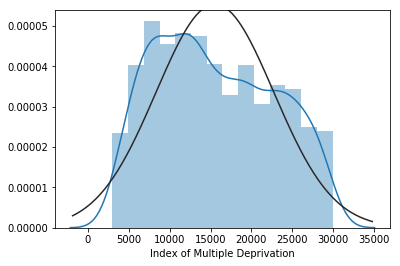

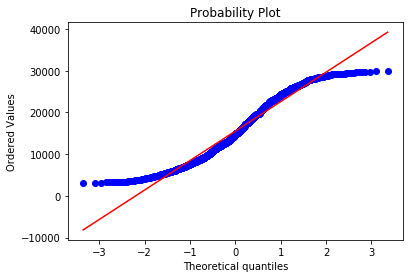

In [841]:
#Now let's have a look at the distribution again

sns.distplot(filtered_df['Index of Multiple Deprivation'], fit=norm)
fig=plt.figure()
stats.probplot(filtered_df['Index of Multiple Deprivation'], plot=plt)


print("Skewness: %f" % filtered_df['Index of Multiple Deprivation'].skew())
print("Kurtosis: %f" % filtered_df['Index of Multiple Deprivation'].kurt())

Although removing outliers did slightly reduce the skewness, the fit is still relatively poor at the end. However, before removing any more data, we shall examine the distribution again with log-transformed data.

Skewness: -0.669634
Kurtosis: -0.288680


C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


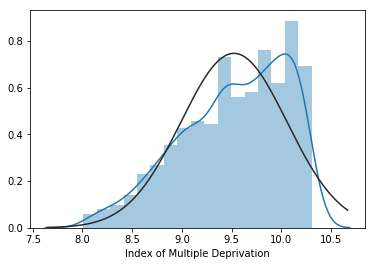

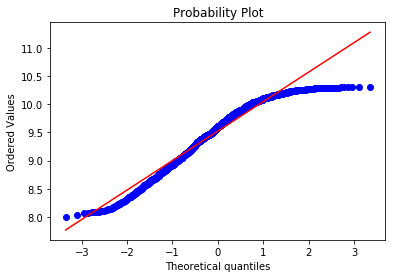

In [856]:
log_index=np.log(filtered_df['Index of Multiple Deprivation'])
sns.distplot(log_index, fit=norm)
fig=plt.figure()
stats.probplot(log_index, plot=plt)


print("Skewness: %f" % np.log(log_index).skew())
print("Kurtosis: %f" % np.log(log_index).kurt())

In [871]:
filtered_df.head()

,Latitude,Longitude,Distance to station,Index of Multiple Deprivation,Quality,Value,Code
0,51.29,0.06,6.12000,19725.000000,1.000000,575544.000000,E05000117
1,51.29,0.07,6.74000,19725.000000,1.000000,575544.000000,E05000117
2,51.30,0.02,5.03625,23230.000000,1.875000,378844.000000,E05000107
3,51.30,0.03,5.18200,25924.000000,1.000000,378844.000000,E05000107
4,51.30,0.04,5.92000,20042.636364,2.272727,539780.363636,E05000107


It does fit the normal distribution better now but the upper range is a bit off. We shall not remove any outliers for now.
Let's examine its association with price value again.

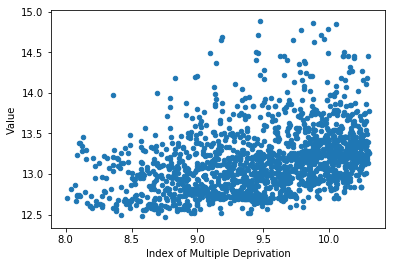

In [875]:

data=pd.concat([np.log(filtered_df['Index of Multiple Deprivation']), np.log(filtered_df['Value'])],axis=1)
data.plot.scatter(x='Index of Multiple Deprivation',y='Value')

In [864]:
from scipy.stats import linregress
linregress(log_index, np.log(filtered_df['Value']))

LinregressResult(slope=0.26248303477142465, intercept=10.660311630284452, rvalue=0.3542345070238794, pvalue=1.1731932992157074e-52, stderr=0.016611930473209174)

From the results above, we could see the deprivation index is indeed significantly and positively correlated with the price value. Therefore, we will keep it as our feature variable.

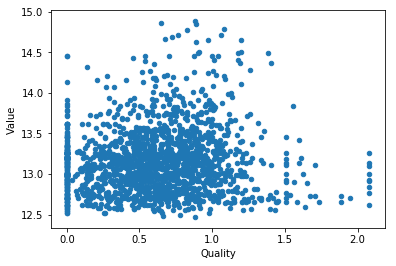

In [876]:
#Now move on the third candidate variable:Quality rating
var='Quality'
data=pd.concat([transformed_price,np.log(filtered_df[var])],axis=1)
data.plot.scatter(x=var,y='Value')

As shown above, the quality rating failed to provide any meaningful information about the price value, therefore, it will not be included in the modelling stage. Taken together, among the three candiate variables, only the depreivation index is retained as the feature variable. We shall now move on to source venue data using Foursquare API.

In [317]:
def getNearbyVenues(area_code,price,deprivation_index,latitude,longitude,radius=500):
    
    venues_list=[]
    for area_code,price,index,lat, lng in zip(area_code,price,deprivation_index,latitude,longitude):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        for i in range(3):
            response = requests.get(url).json()['response']
            
            if response.get('groups'):
                results = response['groups'][0]['items']
                break
                
            print('repeating')
            
        if not response.get('groups'):
            continue
                
        venues_list.append([(
            area_code,
            price,
            index,
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [ 
                  'Code',
                  'Price',
                  'Deprivation_index',
                  'District Latitude', 
                  'District Longitude',
                  'Venue',
                  'Venue ID', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [318]:


    
CLIENT_ID='JRMAOQ23QH2AR2G01QNCFARI5IKTISMVT2PHM3D0DXKGHF5N'
CLIENT_SECRET='M1P2CGJKPR0J1N1GMUV0P5CH1BGLFD3SHIPP4YTOFQ4NTATE'
VERSION = '20190128'
LIMIT=100

    

In [877]:
London_venues=getNearbyVenues(area_code=filtered_df['Code'],
                              price=np.log(filtered_df['Value']),
                              deprivation_index=np.log(filtered_df['Index of Multiple Deprivation']),
                              latitude=filtered_df['Latitude'],
                              longitude=filtered_df['Longitude'])



repeating


In [950]:
London_venues.head()

,Code,Price,Deprivation_index,District Latitude,District Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,E05000117,13.263071,9.889642,51.29,0.06,Shampan At The Spinning Wheel,4edb85d6e300851bfad7955e,51.292974,0.056939,Indian Restaurant
1,E05000117,13.263071,9.889642,51.29,0.06,Westerham Heights,59b435445a2c9107744a89d2,51.289698,0.057968,Scenic Lookout
2,E05000117,13.263071,9.889642,51.29,0.06,Biggin Hill Saddlery & Gun Room,5308c801498ebfb5ae1d784d,51.288883,0.058852,Gun Shop
3,E05000117,13.263071,9.889642,51.29,0.06,The Old Farmhouse,4e5d56d0d164ced553f6f6f6,51.293183,0.056939,Bed & Breakfast
4,E05000107,12.844880,10.053200,51.30,0.02,Pinky & Perky Manor,5843fe72d0bb3e5513d37dd9,51.303328,0.018773,Pizza Place


In [321]:
#Checking all the unique venue categories
London_venues['Venue Category'].unique()

array(['Indian Restaurant', 'Scenic Lookout', 'Gun Shop',
       'Bed & Breakfast', 'Pizza Place', 'Stables', 'Restaurant',
       'Supermarket', 'Pool', 'Grocery Store', 'Pub', 'Café',
       'Coffee Shop', 'Golf Course', 'Train Station', 'Platform',
       'English Restaurant', 'Print Shop', 'Construction & Landscaping',
       'Motorcycle Shop', 'Carpet Store', 'Airport Terminal',
       'Pet Service', 'Campground', 'Forest', 'Athletics & Sports',
       'Auto Garage', 'Clothing Store', 'Seafood Restaurant',
       'Fish & Chips Shop', 'Mobile Phone Shop', 'Gym / Fitness Center',
       'Home Service', 'Bar', 'Sports Club', 'Fast Food Restaurant',
       'Rock Club', 'Music Venue', 'Farm', 'IT Services',
       'Massage Studio', 'Airport', 'Airport Service', 'History Museum',
       'Lake', 'Garden Center', 'Convenience Store', 'Bus Stop',
       'Playground', 'Asian Restaurant', 'Park', 'Tea Room',
       'Tennis Court', 'Automotive Shop', 'Business Service',
       'Arts & Crafts 

In [882]:
len(London_venues['Venue Category'].unique())

465

In [951]:
London_venues.shape

(18917, 10)

There seem to be quite a lot of venue categories, it is likely that not all of them are relevant in predicting housing price categories. Due to the large number of candidate features and its relatively large data size, we will use Random Forest, instead of Decision Tree to perform feature selection and calssification. 

In [881]:
#onehot_encoding: converting categorical variables into dummy variables
ld_onehot=pd.get_dummies(London_venues[['Venue Category']],prefix="",prefix_sep="")


In [883]:
ld_onehot.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [884]:
#Inserting back the relevant columns
ld_onehot.insert(loc=0,column='Code',value=London_venues['Code'])
ld_onehot.insert(loc=0, column='Deprivation_index',value=London_venues['Deprivation_index'])
ld_onehot.insert(loc=0,column='Price',value=London_venues['Price'])

In [886]:
#creating a new price category feature by converting the price value into categorical variable by qualtiles
PriceCategory=pd.qcut(London_venues['Price'],3,labels=['low','medium','high'])

In [887]:
ld_onehot.insert(loc=0,column='PriceCategory',value=PriceCategory)

In [888]:
ld_onehot.shape

(18917, 469)

In [899]:
x_1=ld_onehot.iloc[:,2:].drop(columns='Code')
y_1=ld_onehot['PriceCategory']

## Modelling Stage: 
1. Apply the RandomForestClassifier to the whole dataset
2. Record the accuracy score
3. Select the important features
4. Apply the RandomForestClassifier again using the important features
5. Compare the accuracy score to the first model.
6. Apply the K-NearestNeighbours and Support Vector Machines with the selected features.
7. Record the accuracy of each model.
8. Select the model with the best accuracy score.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [900]:
#Performing 20/80 train_test split
x_train_1,x_test_1,y_train_1,y_test_1=train_test_split(x_1,y_1,test_size=0.2,random_state=4)

In [902]:
# Applying RandomForest to the whole dataset
rf=RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf.fit(x_train_1,y_train_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [903]:
#Accuracy of the first RandomForest Model
rf.score(x_test_1,y_test_1)

0.6627906976744186

In [904]:
#Generate a dataframe with the feature importance value array
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_train_1.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [958]:
feature_importances.sort_values('importance',ascending=True).head()

,importance
Lighting Store,0.0
Gaming Cafe,0.0
Military Base,0.0
Student Center,0.0
Cable Car,0.0


In [906]:
#As we can see, there are quite a few features with zero importance values. We shall remove those first.
important_feature=feature_importances[feature_importances['importance']!=0].reset_index()


In [907]:
feature_list=list(important_feature['index'])

In [960]:
#Modifying training and testing dataset accordingly.
x_train_imp=x_train_1[feature_list]
x_test_imp=x_test_1[feature_list]

In [961]:
rf.fit(x_train_imp,y_train_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [962]:
#Accuracy of the second Randomforest model
rf.score(x_test_imp,y_test_1)

0.6619978858350951

In [969]:
len(feature_list)

451

Dropping features with zero importance did not improve our model performance. This is within our expectations as we still have a large number of feature variables left, which might contains variables that provide little meaningful information for price categoriy prediction, thereby introducing noise to the model. We shall now examine the impact of further feature reduction on model performance.

In [963]:
#Setting the feature selection threshold : importance_rank >= 0.0015
impt_fea_2=list(feature_importances[feature_importances['importance']>=0.0015].reset_index()['index'])

In [964]:
len(impt_fea_2)

28

In [965]:
x_impt_train_2=x_train_1[impt_fea_2]
x_impt_test_2=x_test_1[impt_fea_2]

In [966]:
rf.fit(x_impt_train_2,y_train_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [967]:
rf.score(x_impt_test_2,y_test_1)

0.8168604651162791

By further reducing the number of feature variables, we have significantly improved our model accuracy. Now we will apply KNN and SVM to the selected feature sets.

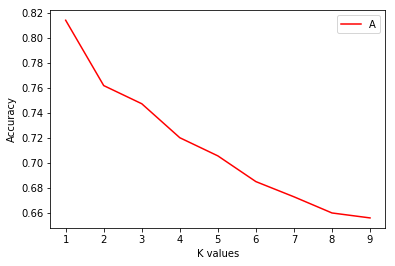

The best accuracy was obtained when K= 1 with Jaccard score= 0.8142177589852009


In [947]:
##Applying KNN algorithm
Ks=10
mean_acc=np.zeros(9)
std_acc=np.zeros(9)
for n in range (1,Ks):
    neigh=KNeighborsClassifier(n_neighbors=n).fit(x_impt_train_2,y_train_1)
    yhat=neigh.predict(x_impt_test_2)
    mean_acc[n-1]=metrics.accuracy_score(y_test_1,yhat)

plt.plot(range(1,Ks), mean_acc, 'r')
plt.legend('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('K values')
plt.show()

print( "The best accuracy was obtained when K=",  mean_acc.argmax()+1, "with Jaccard score=",mean_acc.max())

In [551]:

def SVM(x_train,y_train,x_test,y_test,KERNEL):
    svm_all=svm.SVC(kernel=KERNEL)
    svm_all.fit(x_train,y_train)
    yhat_svm_all=svm_all.predict(x_test)
    print(metrics.accuracy_score(y_test,yhat))
    svm_all_matrix=confusion_matrix(y_test,yhat_svm_all,labels=['high','medium','low'])
    np.set_printoptions()
    print(classification_report(y_test,yhat_svm_all))

In [948]:
SVM(x_train=x_train_1,y_train=y_train_1,x_test=x_test_1,y_test=y_test_1,KERNEL='poly')


0.6559196617336153
             precision    recall  f1-score   support

       high       0.00      0.00      0.00      1239
        low       0.54      0.22      0.32      1307
     medium       0.32      0.84      0.46      1238

avg / total       0.29      0.35      0.26      3784



C:\Users\helen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [949]:
SVM(x_train=x_impt_train_2,y_train=y_train_1,x_test=x_impt_test_2,y_test=y_test_1,KERNEL='poly')


0.6559196617336153
             precision    recall  f1-score   support

       high       0.43      0.56      0.48      1239
        low       0.46      0.56      0.51      1307
     medium       0.37      0.18      0.24      1238

avg / total       0.42      0.43      0.41      3784



Compared to KNN and SVMs, RandomForestClassifier yielded the highest accuracy score(81.69%). Therefore, it is chosen as the best classfication model. 


Upon a closer inspection, however, the relatively high accuracy score does not provide any direct evidence for the strong predictive power of nearby venue category data. This is because,as shown in the feature_importances dataframe, the feature with the highest contribution value is the index of multiple deprivation. More importantly, its associated contribution value exceeded the value of the second most important feature by quite a considerable margin. Therefore it is possible that, venue categories data played a relatively insignificant role in predicting housing price categories. There are several possible explanations for this result. 

Firstly, this could be attributed to the lack of relationship between housing price categories and its nearby venue categories. Secondly, since the price value did not perfectly fit the normal distribution, it is possible that converting price values into cateogircal variables by quartiles might have resulted in a loss of information. Thus, the resulting classification model might not be a perfect reflection of the actual relationship between housing price and its nearby venue categories. Thirdly, the nearby venue data is limited to its functional categories, which provide little information about its associated expenditure level, which could potentially be a better predictor of housing price categories. This information could be sourced using the 'get venue details' query, however, due to the relatively large data size,
the number of API calls will exceed the quota of the current starndard Foursquare developer account. Therefore, future research with the additional focus on household expenditure level is suggested.

In [970]:
feature_importances.sort_values('importance',ascending=False).head()

,importance
Deprivation_index,0.770989
Fast Food Restaurant,0.004034
French Restaurant,0.003396
Bus Stop,0.002408
Airport Lounge,0.002338


## References
Basu, S., & Thibodeau, T. G. (1998). Analysis of spatial autocorrelation in house prices. The Journal of Real Estate Finance and Economics, 17(1), 61-85.

Islam, K. S., & Asami, Y. (2009, July). Housing market segmentation: a review. In Review of Urban & Regional Development Studies: Journal of the Applied Regional Science Conference (Vol. 21, No. 2‐3, pp. 93-109). Melbourne, Australia: Blackwell Publishing Asia.

Margulis, H. L. (1998). Predicting the growth and filtering of at-risk housing: Structure ageing, poverty and redlining. Urban Studies, 35(8), 1231-1259.

